In [2]:
# chargement des bibliothèques
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
# Chargement et exploration des données
data_dir = "drive/MyDrive/Bloc4Viken/utkcropped"
file_paths = []
ages = []

for file in os.listdir(data_dir):
    if file.endswith(".jpg"):
        age = int(file.split("_")[0])
        file_paths.append(os.path.join(data_dir, file))
        ages.append(age)

In [4]:
# Création d'un DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

df = pd.DataFrame({"file_path": file_paths, "age": ages})
df.head()

,file_path,age
0,drive/MyDrive/Bloc4Viken/utkcropped/80_0_0_20170117175546325.jpg.chip.jpg,80
1,drive/MyDrive/Bloc4Viken/utkcropped/80_1_0_20170109142913604.jpg.chip.jpg,80
2,drive/MyDrive/Bloc4Viken/utkcropped/80_0_0_20170117174418358.jpg.chip.jpg,80
3,drive/MyDrive/Bloc4Viken/utkcropped/80_1_0_20170110131358567.jpg.chip.jpg,80
4,drive/MyDrive/Bloc4Viken/utkcropped/80_0_0_20170120225045833.jpg.chip.jpg,80


In [5]:
# affichage du nombre de lignes et de colonnes du dataframe
df.shape

(23744, 2)

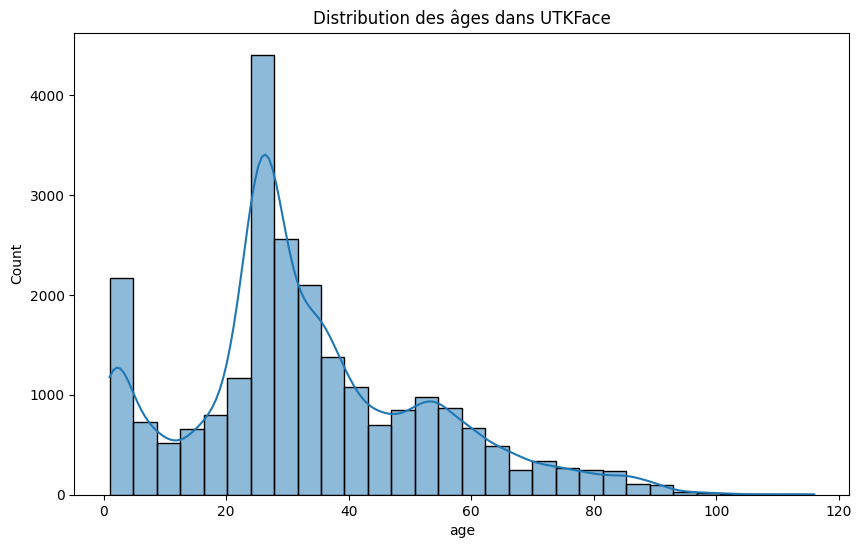

In [6]:
# Visualisation de la distribution des âges
plt.figure(figsize=(10, 6))
sns.histplot(df["age"], bins=30, kde=True)
plt.title("Distribution des âges dans UTKFace")
plt.show()

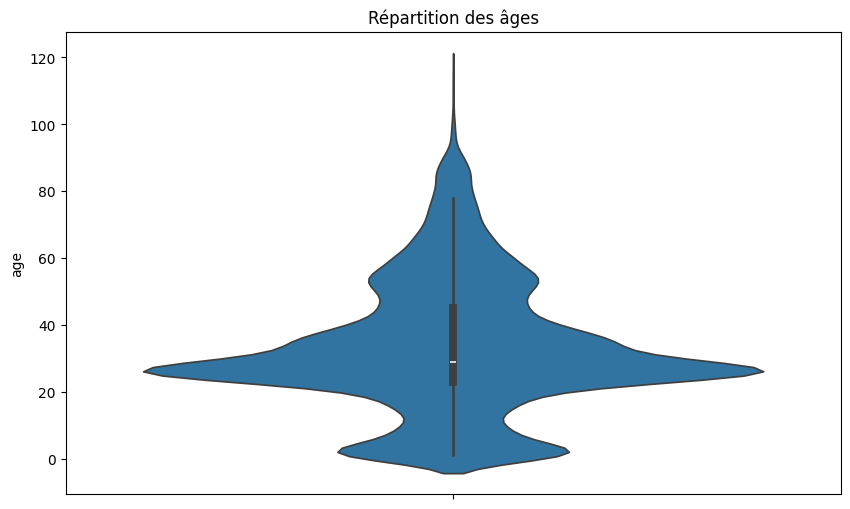

In [7]:
# Violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(y=df["age"])
plt.title("Répartition des âges")
plt.show()

In [25]:
df.describe()

,age
count,23744.000000
mean,33.323408
std,19.864859
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


In [8]:
# Préparation des données
img_height, img_width = 200, 200
batch_size = 32

In [9]:
def process_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_height, img_width]) / 255.0
    return img, label

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df["file_path"], df["age"], test_size=0.2, random_state=42)

In [11]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(process_image).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(process_image).batch(batch_size)

In [12]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [13]:
# Modèle CNN pour la régression (prédiction d'âge)
model_regression = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [14]:
model_regression.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [16]:
# Entraînement
checkpoint_path = "drive/MyDrive/Bloc4Viken/age_detect_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=False, verbose=1)

history_reg = model_regression.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 465s 762ms/step - loss: 1047.3817 - mae: 27.3877 - val_loss: 312.7314 - val_mae: 14.1498
Epoch 2/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 116s 126ms/step - loss: 170.6923 - mae: 9.9505 - val_loss: 223.3494 - val_mae: 11.6148
Epoch 3/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 76s 128ms/step - loss: 156.1699 - mae: 9.4212 - val_loss: 149.0769 - val_mae: 9.0164
Epoch 4/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 82s 129ms/step - loss: 138.6785 - mae: 8.9497 - val_loss: 169.1923 - val_mae: 10.0881
Epoch 5/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 89s 140ms/step - loss: 135.7835 - mae: 8.7958 - val_loss: 234.8522 - val_mae: 11.5411
Epoch 6/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 83s 139ms/step - loss: 133.8489 - mae: 8.7852 - val_loss: 114.6416 - val_mae: 8.2516
Epoch 7/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 137s 131ms/step - loss: 117.0907 - mae: 8.1737 - val_loss: 180.3058 - val_mae: 10.1056
Epoch 8/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 79s 133ms/step - loss: 124.0538 - mae: 8.4300 - val_loss: 100.7012 - val_ma

In [20]:
# Modèle CNN pour la classification par classes d'âge
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
labels = [0, 1, 2, 3, 4, 5, 6]
df["age_group"] = pd.cut(df["age"], bins=bins, labels=labels)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df["file_path"], df["age_group"].astype(int), test_size=0.2, random_state=42)
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(process_image).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(process_image).batch(batch_size)


In [22]:
model_classification = Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(labels), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [23]:
model_classification.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Entraînement
checkpoint_path = "drive/MyDrive/Bloc4Viken/age_classif_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, save_best_only=False, verbose=1)

history_class = model_classification.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 86s 138ms/step - accuracy: 0.3986 - loss: 1.7011 - val_accuracy: 0.2262 - val_loss: 2.2608
Epoch 2/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 74s 124ms/step - accuracy: 0.5179 - loss: 1.2012 - val_accuracy: 0.4464 - val_loss: 1.3819
Epoch 3/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 82s 124ms/step - accuracy: 0.5548 - loss: 1.0979 - val_accuracy: 0.4481 - val_loss: 1.4806
Epoch 4/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 75s 126ms/step - accuracy: 0.5728 - loss: 1.0430 - val_accuracy: 0.5302 - val_loss: 1.1810
Epoch 5/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - accuracy: 0.5873 - loss: 0.9980 - val_accuracy: 0.5294 - val_loss: 1.2070
Epoch 6/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 83s 140ms/step - accuracy: 0.6041 - loss: 0.9703 - val_accuracy: 0.3902 - val_loss: 1.4331
Epoch 7/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 139s 136ms/step - accuracy: 0.6167 - loss: 0.9408 - val_accuracy: 0.5287 - val_loss: 1.1597
Epoch 8/15
594/594 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - accuracy: 0.6165 - loss: 

In [26]:
# Évaluation
y_pred_reg = model_regression.predict(test_data).flatten()
y_pred_class = np.argmax(model_classification.predict(test_data), axis=1)


149/149 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step


In [27]:
mae = np.mean(np.abs(y_pred_reg - y_test))
accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
cm = confusion_matrix(y_test, y_pred_class)

In [28]:
# Affichage des résultats
print(f"MAE (Régression) : {mae}")
print(f"Accuracy (Classification) : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1-score : {f1}")
print("Matrice de confusion :\n", cm)

MAE (Régression) : 32.94392261077891
Accuracy (Classification) : 0.5797009896820383
Precision : 0.585956255100324
Recall : 0.5797009896820383
F1-score : 0.571828450306082
Matrice de confusion :
 [[ 549   63   16    0    5    7    7]
 [  37  125  122    7   18    8    2]
 [  12   86 1079  187  188   21    4]
 [   6    9  296  189  314   43    1]
 [   1    5   54   40  531  232   21]
 [   0    1    3    1   84  208   66]
 [   0    1    0    0    0   28   72]]


-**Régression (MAE)**:

-Dans le cas de la détection d'âge, si l'âge moyen est autour de 33 ans (comme mentionné dans les statistiques descriptives), un MAE de 32.94 pourrait indiquer qu'en moyenne, le modèle se trompe de près de 33 ans, ce qui est assez important. Pour améliorer cette métrique, essayer des architectures plus complexes, ajuster le taux d'apprentissage, ou explorer des modèles pré-entraînés.

-**Classification (Accuracy, Precision, Recall, F1-Score)** :

-**Accuracy = 57.97%**: le modèle réussit à prédire correctement environ 58% des classes d'âge, ce qui n'est pas très élevé. Cependant, cela peut être influencé par des classes déséquilibrées ou des données difficiles à interpréter pour le modèle (cas de photos floues par exemple).

-**Precision = 58.60%** : si la precision est relativement proche de l'accuracy, cela peut signifier que le modèle est relativement équilibré dans ses prédictions, mais cette métrique peut également être affectée par des déséquilibres de classe.

-**Recall = 57.97%** :comme la precision, un recall similaire à l'accuracy indique que le modèle ne parvient pas à identifier certains cas de manière fiable, mais il pourrait être bon pour d'autres. Si le modèle ne parvient pas à identifier des tranches d'âge spécifiques, le recall peut souffrir, ce qui serait typique pour un dataset déséquilibré.

-**F1-score = 57.18%** : un F1-score autour de 57.18% indique que le modèle est relativement équilibré en termes de précision et de rappel, mais qu'il y a encore de la place pour l'amélioration, en particulier si on veut des prédictions plus fiables pour chaque classe d'âge.

-**Matrice de Confusion** :

-**la classe 2-5 ans et 25-30 ans** semble sur-représentée par rapport aux autres classes. Cela se voit dans les grandes diagonales des premières lignes (classes jeunes) et la classe d'âge 25-30. Il y a aussi une forte confusion entre certaines classes, en particulier :

-**la classe [2-5]** (ligne 1) se confond avec plusieurs autres classes (avec un grand nombre d'exemples mal classés comme classes plus jeunes ou plus âgées).

-**la classe [15-25]** est également confuse avec les classes adjacentes, probablement en raison de la complexité de l'âge en transition.

-le fait que les valeurs diagonales ne soient pas toutes élevées suggère que le modèle n'a pas encore parfaitement appris à distinguer les tranches d'âge, notamment les classes avec moins de données d'entraînement.



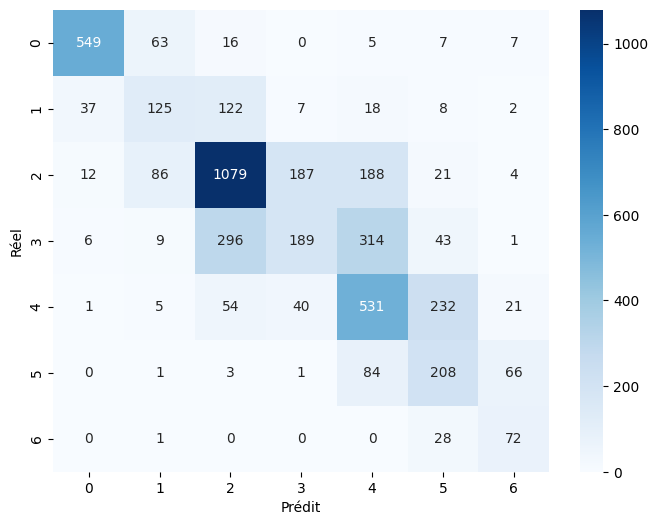

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

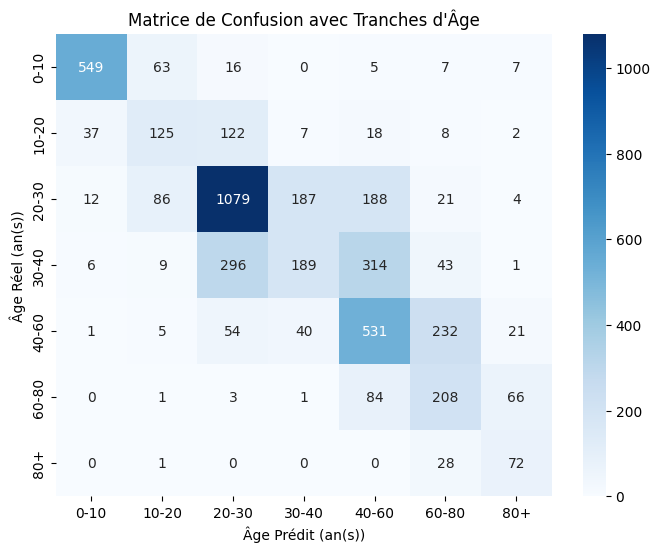

In [39]:
# Affichage de la heatmap avec les bonnes étiquettes pour les classes
plt.figure(figsize=(8, 6))

# Remplacer les étiquettes par les tranches d'âge dans la matrice de confusion
age_groups = ['0-10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']  # Correspond aux labels des bins

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=age_groups, yticklabels=age_groups)

plt.xlabel("Âge Prédit (an(s))")
plt.ylabel("Âge Réel (an(s))")
plt.title("Matrice de Confusion avec Tranches d'Âge")
plt.show()

In [31]:
# Récupérer les valeurs de loss et MAE depuis l'entraînement
loss = history_reg.history['loss']
val_loss = history_reg.history['val_loss']
mae = history_reg.history['mae']
val_mae = history_reg.history['val_mae']

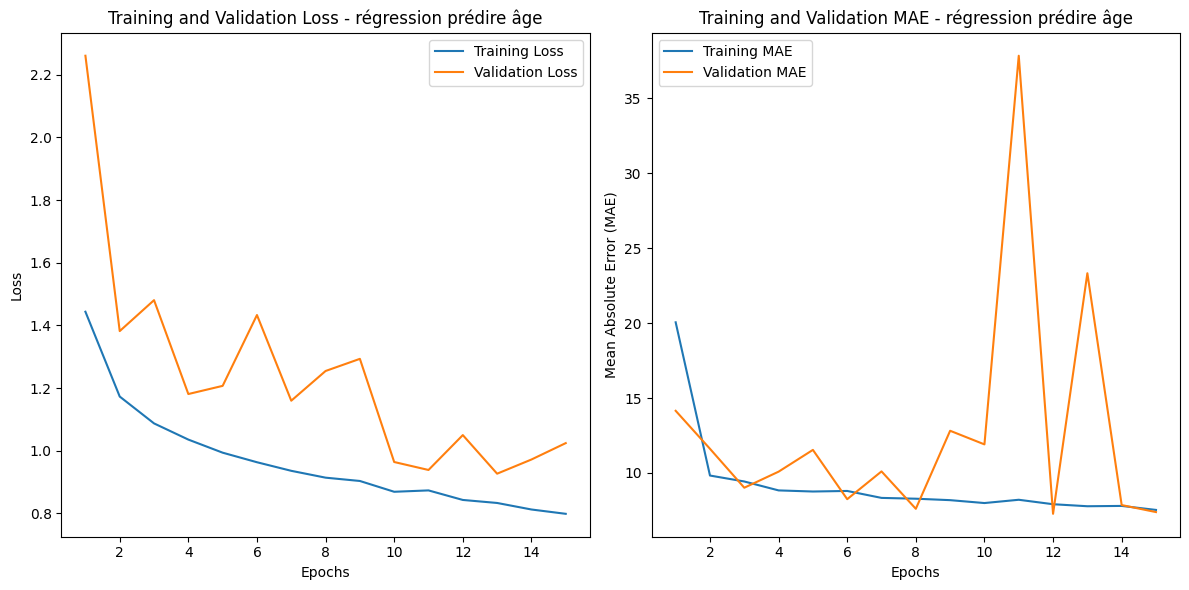

In [40]:
# Tracer les courbes de loss et MAE
plt.figure(figsize=(12, 6))

# Courbes de Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), loss, label="Training Loss")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - régression prédire âge')
plt.legend()

# Courbes de MAE (Mean Absolute Error)
plt.subplot(1, 2, 2)
plt.plot(range(1, 16), mae, label="Training MAE")
plt.plot(range(1, 16), val_mae, label="Validation MAE")
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE - régression prédire âge')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()

-**Oscillation des performances** : grande oscillation dans la performance du modèle sur les données de validation (voir le 9e et le 11e epoch). Cela peut suggérer que le modèle sur-apprend certaines parties de l'ensemble d'entraînement, mais il a du mal à se généraliser aux données de validation

-**Sur-apprentissage possible** : Si les performances du modèle sur les données d'entraînement continuent à s'améliorer alors que celles sur les données de validation stagnent ou se détériorent, cela indique souvent un overfitting.


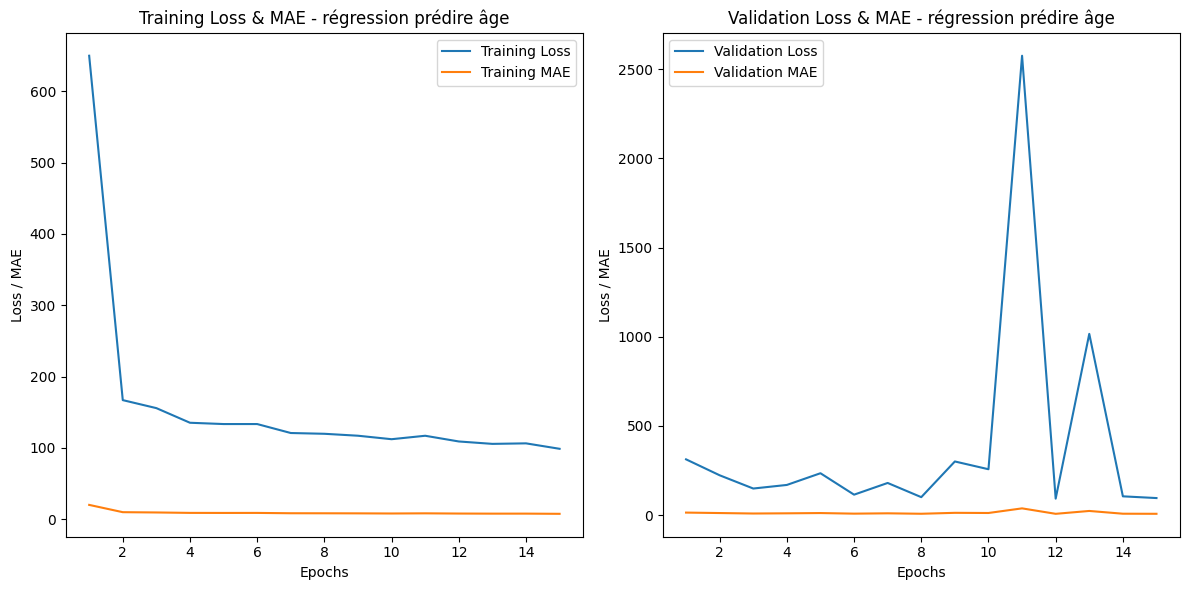

In [33]:
# Tracer les courbes de loss et MAE pour l'entraînement et la validation
plt.figure(figsize=(12, 6))

# Loss et MAE pour l'entraînement
plt.subplot(1, 2, 1)
# Courbe de Loss pour l'entraînement
plt.plot(range(1, 16), loss, label="Training Loss")
# Courbe de MAE pour l'entraînement
plt.plot(range(1, 16), mae, label="Training MAE")
plt.xlabel('Epochs')
plt.ylabel('Loss / MAE')
plt.title('Training Loss & MAE - régression prédire âge')
plt.legend()

# Loss et MAE pour la validation
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, deuxième vignette
# Courbe de Loss pour la validation
plt.plot(range(1, 16), val_loss, label="Validation Loss")
# Courbe de MAE pour la validation
plt.plot(range(1, 16), val_mae, label="Validation MAE")
plt.xlabel('Epochs')
plt.ylabel('Loss / MAE')
plt.title('Validation Loss & MAE - régression prédire âge')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()


-**améliorations possibles**:

-**plus d'épochs ou ajustement des hyperparamètres** : un peu plus de temps d'entraînement avec un taux d'apprentissage ajusté ou l'utilisation de techniques comme l'early stopping peut aider à prévenir le sur-apprentissage

-**régularisation** : ajout de dropout ou régularisation L2 (penalité sur les poids du modèle) peut aider à limiter le sur-apprentissage

-**possible déséquilibrage des données de validation** : undersampling des classes sur-représentées (0-5 ans et 25-30 ans)

In [34]:
# Récupération des données d'accuracy et de loss (classification multi-classes)
acc = history_class.history['accuracy']
val_acc = history_class.history['val_accuracy']
loss = history_class.history['loss']
val_loss = history_class.history['val_loss']


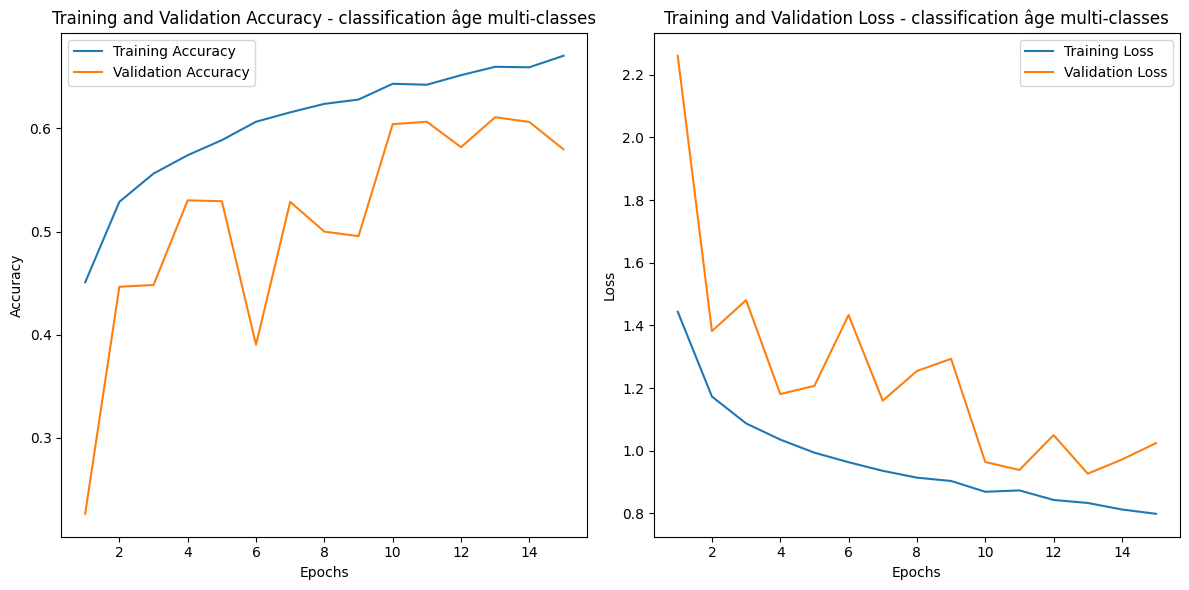

In [35]:
# Tracer les courbes de comparaison de l'accuracy et de loss entre training et validation (test)
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, 16), acc, label="Training Accuracy")
plt.plot(range(1, 16), val_acc, label="Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy - classification âge multi-classes')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, 16), loss, label="Training Loss")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - classification âge multi-classes')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()

-**accuracy d'entraînement** : l'accuracy d'entraînement passe de 39.86% (au début) à 66.61% (à la fin). C'est une amélioration notable, mais cette performance pourrait encore être améliorée pour obtenir un modèle plus robuste

-**perte d'entraînement** : la perte d'entraînement diminue également, passant de 1.7011 à 0.8025, ce qui indique que le modèle s'améliore au fur et à mesure de l'entraînement. Elle reste relativement élevée à la fin, ce qui suggère que le modèle pourrait ne pas avoir convergé complètement

-**accuracy de validation** : la validation accuracy est plus volatile, avec une tendance générale à augmenter dans les premières epochs, atteignant un maximum de 60.41% à la 10ème epoch, puis redescendant à 57.97% à la fin. Cette fluctuation de la validation accuracy pourrait suggérer un phénomène de surapprentissage (overfitting) ou une instabilité dans l'apprentissage. Le modèle peut apprendre trop bien les exemples d'entraînement au détriment de sa capacité à généraliser

-**loss de validation** : la perte de validation a un comportement similaire à l'accuracy de validation, avec une amélioration initiale, mais la perte reste assez élevée à la fin (1.0243). Cela peut être lié à une sous-performance sur des classes moins représentées ou des aspects difficiles à apprendre du dataset (par exemple, des classes d'âge peu fréquentes).



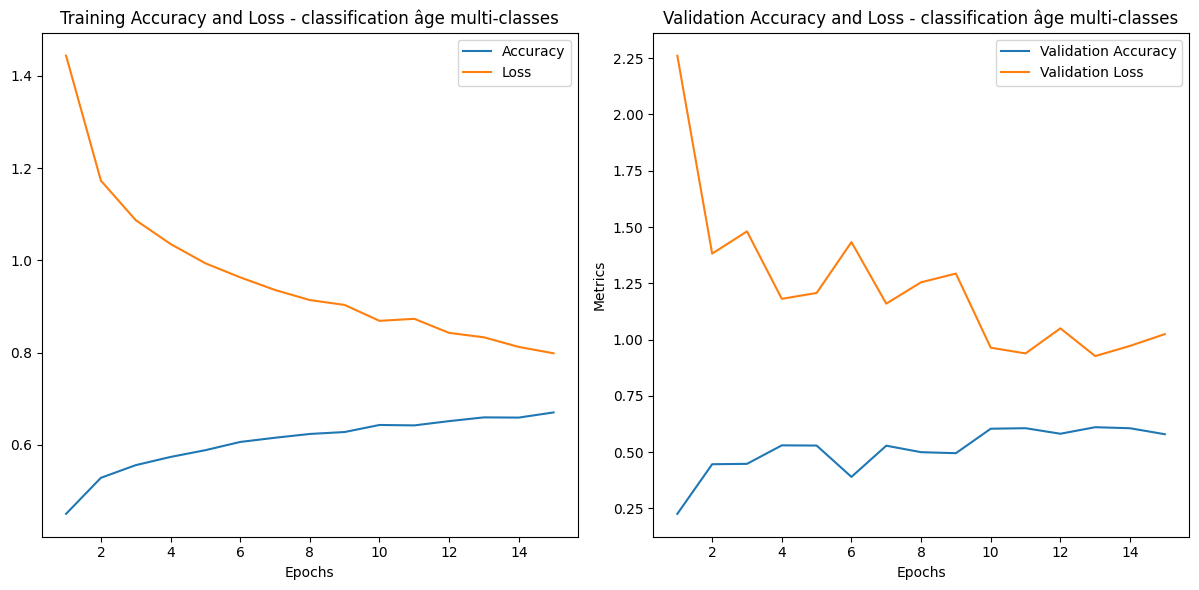

In [36]:
# Tracer pour chacun des ensembles d'entraînement et de test les courbes de l'accuracy et de loss
plt.figure(figsize=(24, 6))  # Augmenter la largeur pour accueillir 4 subplots

# Training Accuracy and Loss
plt.subplot(1, 4, 3)  # 1 ligne, 4 colonnes, 3e subplot
plt.plot(range(1, 16), acc, label="Accuracy")
plt.plot(range(1, 16), loss, label="Loss")
plt.xlabel('Epochs')
plt.title('Training Accuracy and Loss - classification âge multi-classes')
plt.legend()

# Validation Accuracy and Loss
plt.subplot(1, 4, 4)  # 1 ligne, 4 colonnes, 4e subplot
plt.plot(range(1, 16), val_acc, label="Validation Accuracy")
plt.plot(range(1, 16), val_loss, label="Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Validation Accuracy and Loss - classification âge multi-classes')
plt.legend()

# Affichage des graphiques
plt.tight_layout()
plt.show()


-**améliorations possibles** :

-**équilibrage des classes (Undersampling / Oversampling)**: les classes déséquilibrées dans le dataset peuvent expliquer pourquoi l'accuracy est plus faible sur la validation. Appliquer des techniques d'undersampling ou d'oversampling pour rendre le dataset plus équilibré et utiliser des poids de classe.

-**ajustement du modèle** : si la perte d'entraînement diminue mais que la performance de validation n'augmente pas beaucoup, augmenter la complexité du modèle (ajouter des couches ou des neurones) ou essayer des modèles pré-entraînés comme ResNet ou EfficientNet . Ajuster aussi le taux d'apprentissage car s'il est trop élevé, cela peut faire osciller l'entraînement et empêcher le modèle de converger correctement.

-**Early Stopping** : implémenter un early stopping pour éviter le surapprentissage et arrêter l'entraînement lorsque la performance sur la validation commence à se détériorer. Cela permet d'éviter que le modèle apprenne des spécificités des données d'entraînement qui ne se généralisent pas bien aux nouvelles données.

-**Tuning de l'architecture du modèle** : tester différentes architectures de réseaux de neurones (par exemple, plus de couches ou un type de réseau pré-entraîné comme mentionné précédemment).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step


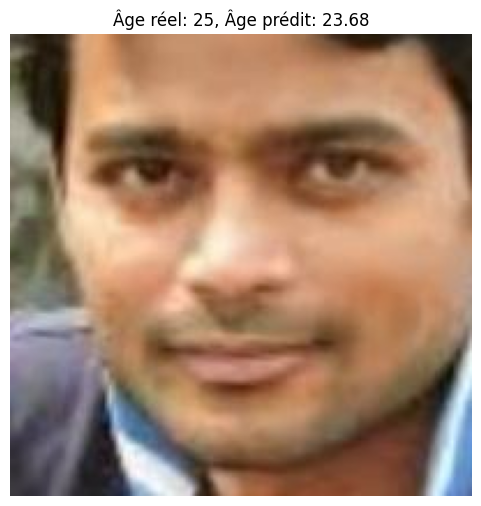

'import random\n\n# Sélectionner une image au hasard à partir de l\'ensemble de test\nrandom_index = random.randint(0, len(X_test) - 1)\nfile_path = X_test.iloc[random_index]\nreal_age = y_test.iloc[random_index]\n\n# Charger et prétraiter l\'image\nimage, _ = process_image(file_path, real_age)\n\n# Affichage de l\'image\nplt.figure(figsize=(6, 6))\nplt.imshow(image)\nplt.axis(\'off\')\n\n# Prédire l\'âge de l\'image avec le modèle de régression\npredicted_age = model_regression.predict(tf.expand_dims(image, axis=0)).flatten()[0]\n\n# Afficher l\'âge réel et prédit sur l\'image\nplt.title(f"Âge réel: {real_age}, Âge prédit: {predicted_age:.2f}")\nplt.show()\n'

In [37]:
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# Chemin du dossier contenant les images du dataset n'ayant ni participé à l'entraînement ni participé au test du modèle de détection de l'âge
test_folder = "drive/MyDrive/Bloc4Viken/utkcroppedpredict"

# Lister tous les fichiers d'images dans le dossier
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.chip'))]

# Vérifier s'il y a des images dans le dossier
if not image_files:
    print("Aucune image trouvée dans le dossier !")
else:
    # Sélectionner un fichier image au hasard
    random_file = random.choice(image_files)
    file_path = os.path.join(test_folder, random_file)

    # Extraire l'âge réel à partir du nom du fichier (avant le premier "_")
    real_age = int(random_file.split("_")[0])  # Prend la partie avant le premier "_"

    # Charger et prétraiter l'image
    image, _ = process_image(file_path, real_age)  # Passer l'âge réel pour affichage si nécessaire

    # Affichage de l'image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')

    # Prédire l'âge avec le modèle
    predicted_age = model_regression.predict(tf.expand_dims(image, axis=0)).flatten()[0]

    # Afficher l'âge réel et l'âge prédit
    plt.title(f"Âge réel: {real_age}, Âge prédit: {predicted_age:.2f}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


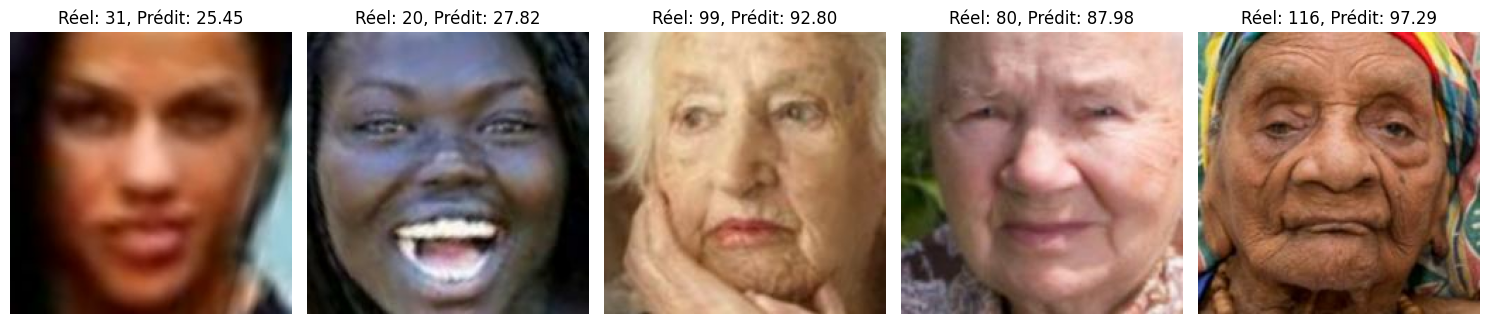

'# Nombre d\'images à afficher\nnum_images = 5\n\n# Créer une figure pour afficher les images\nplt.figure(figsize=(15, 15))\n\n# Sélectionner et afficher plusieurs images aléatoires\nfor i in range(num_images):\n    random_index = random.randint(0, len(X_test) - 1)\n    file_path = X_test.iloc[random_index]\n    real_age = y_test.iloc[random_index]\n\n    # Charger et prétraiter l\'image\n    image, _ = process_image(file_path, real_age)\n\n    # Prédire l\'âge de l\'image avec le modèle de régression\n    predicted_age = model_regression.predict(tf.expand_dims(image, axis=0)).flatten()[0]\n\n    # Afficher l\'image dans un sous-graphe (médaillon)\n    plt.subplot(1, num_images, i + 1)  # 1 ligne et \'num_images\' colonnes\n    plt.imshow(image)\n    plt.axis(\'off\')\n\n    # Afficher l\'âge réel et prédit sur l\'image\n    plt.title(f"Réel: {real_age}, Prédit: {predicted_age:.2f}")\n\n# Affichage de toutes les images\nplt.tight_layout()\nplt.show()'

In [38]:
# Nombre d'images à afficher
num_images = 5

# Lister tous les fichiers d'images dans le dossier
image_files = [f for f in os.listdir(test_folder) if f.endswith(('.jpg', '.png', '.jpeg', '.chip'))]

# Vérifier s'il y a suffisamment d'images dans le dossier
if len(image_files) < num_images:
    print(f"Seulement {len(image_files)} images disponibles, ajustez `num_images`.")
else:
    # Créer une figure pour afficher les images
    plt.figure(figsize=(15, 15))

    # Sélectionner et afficher plusieurs images aléatoires
    for i in range(num_images):
        # Sélectionner un fichier image au hasard
        random_file = random.choice(image_files)
        file_path = os.path.join(test_folder, random_file)

        # Extraire l'âge réel à partir du nom du fichier (avant le premier "_")
        real_age = int(random_file.split("_")[0])  # Prend la partie avant le premier "_"

        # Charger et prétraiter l'image
        image, _ = process_image(file_path, real_age)  # Passer l'âge réel pour affichage si nécessaire

        # Prédire l'âge de l'image avec le modèle de régression
        predicted_age = model_regression.predict(tf.expand_dims(image, axis=0)).flatten()[0]

        # Afficher l'image dans un sous-graphe (médaillon)
        plt.subplot(1, num_images, i + 1)  # 1 ligne et 'num_images' colonnes
        plt.imshow(image)
        plt.axis('off')

        # Afficher l'âge réel et prédit sur l'image
        plt.title(f"Réel: {real_age}, Prédit: {predicted_age:.2f}")

    # Affichage de toutes les images
    plt.tight_layout()
    plt.show()